In [25]:
# импортируйте нужные библиотеки
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn import datasets
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression

In [26]:
# Генерация линейно разделимой выборки
X, y =  make_blobs(n_samples=1000, n_features=2, centers=2, cluster_std=1.05, random_state=20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

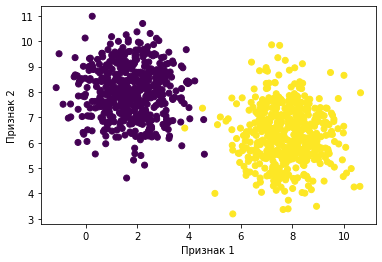

In [27]:
# Визуализация выборки
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.xlabel("Признак 1")
plt.ylabel("Признак 2")
plt.show()

# Логистическая регрессия

Конечным результатом задачи классификации является разбиение множества объектов на классы. Давайте усложним задачу и будем предсказывать не конкретные классы, а вероятности принадлежать им, например, для бинарной классификации мы будем предсказывать одно число, которое будет соответствовать вероятности принадлежать положительному классу. \
Такого результата можно достичь, если мы будем строить линейную регрессию над некоторыми признаками, а затем её результат переводить в отрезок $[0;1]$. В этом нам поможет сигмоидная функция, которая имеет вид:
<p style="text-align: center;"> $f(z) = \dfrac{1}{1 + e^{-z}}$ </p>

![sigmoid.webp](https://cmertin.github.io/images/2016/11/11_17-Loan_Approvals/Sigmoid_Function.png)
<p style="text-align: center;"></p>

Моделью логистической регрессии назовём функцию от весов и объекта вида:

<p style="text-align: center;"> $a(w, x) = \dfrac{1}{1 + e^{-w_0 - w_1x_1 + ... + w_mx_m}}$ </p>

Обучение данной модели происходит за счет кросс-энтропийной или логистическая функции потерь :
<p style="text-align: center;"> $-\sum\limits_{i=1}^{n}(y_ilog(a_i) + (1 - y_i)log(1 - a_i))$ </p>
где $a_i = a(w, x_i)$

#### Задание №1. Выведите шаг градиентного спуска для логистической функции потерь (приложить фото)

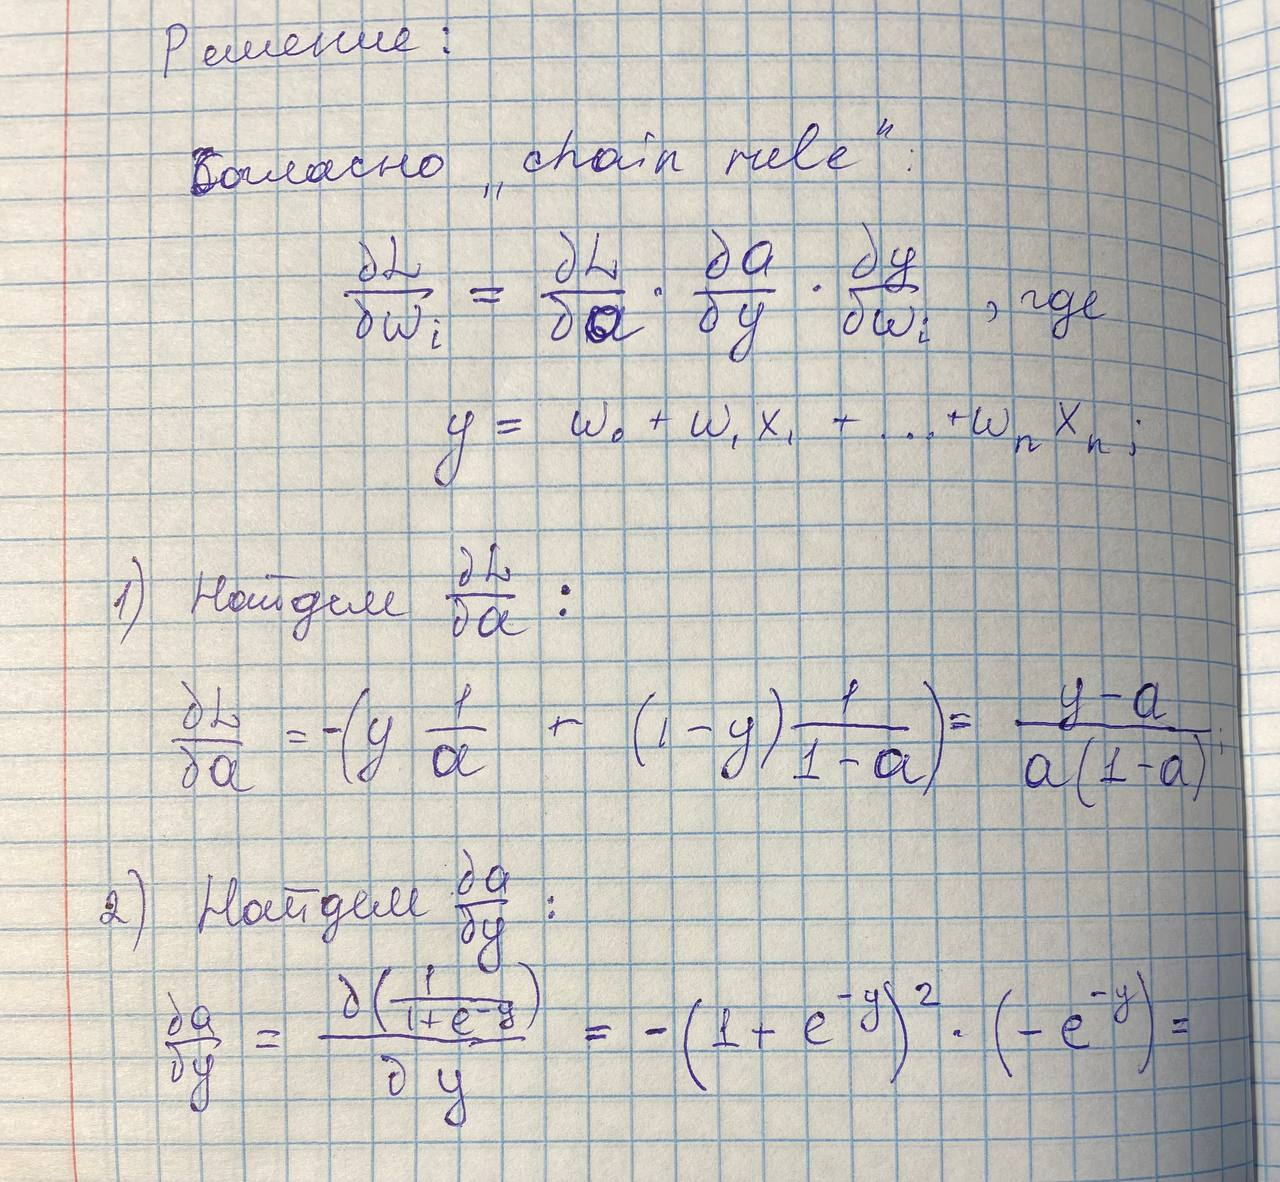

In [28]:
from IPython.display import Image
Image(filename='1.jpg')

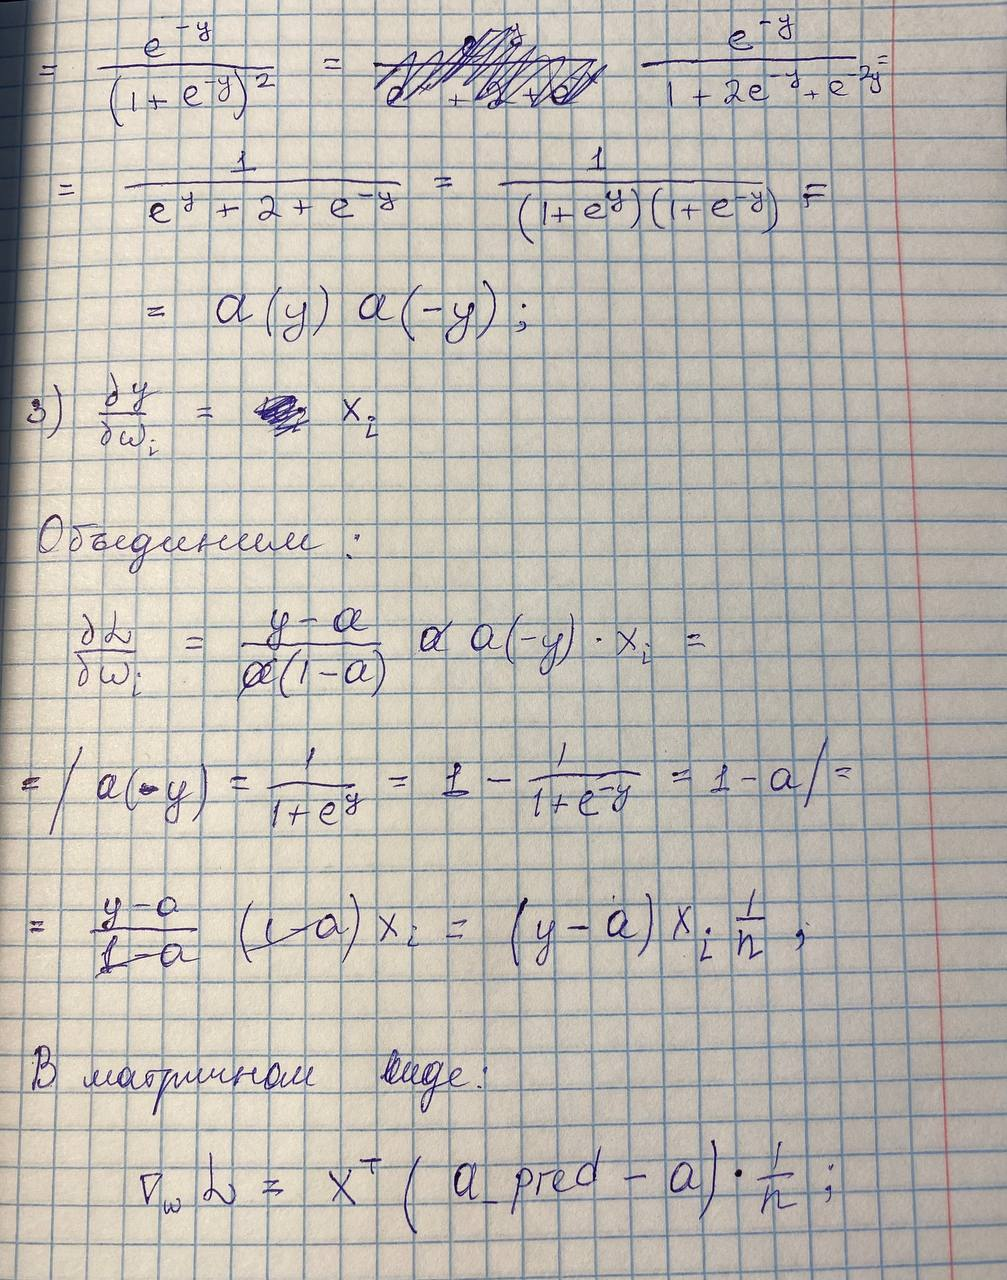

In [29]:
Image(filename='2.jpg')

#### Задание №2. Напишите собственную логистическую регрессию

In [30]:
class MyLogRegression():
    
    def __init__(self):
        self.w = None
        self.loss_history = []
 
    def add_one(self, X):
        
        return np.insert(X, 0, 1, axis=1)
    
    def sigmoid(self, value):
        
        if value >= 0:
            return 1 / (1 + np.exp(-value))
        else:
            return np.exp(value) / (np.exp(value) + 1)
        
    def matr_sigm(self, X, w):
        
        X, w = X.copy(), w.copy()
        z = np.dot(X, w)
        return np.array([self.sigmoid(element) for element in z])
    
    def mistake(self, a, a_pred):
        
        # рассчитаем функцию потерь для a = 1, добавив 1e-9, чтобы избежать ошибки при log(0)
        a_one_loss = a * np.log(a_pred + 1e-9)
 
        # также рассчитаем функцию потерь для a = 0
        a_zero_loss = (1 - a) * np.log(1 - a_pred + 1e-9)
 
        # сложим и разделим на количество наблюдений
        return -np.mean(a_zero_loss + a_one_loss)
    
    
    def gradient(self, X, a, a_pred):
        
        grad = np.dot(X.T, a_pred - a)/len(a)
        return grad
    
    def fit(self, X, a, n = 10000, lr = 0.01):
        
        X, a = self.add_one(X), a.copy()
        
        w = np.zeros(X.shape[1])
 
        loss_history = []
        
        for i in range(n):
            
            a_pred = self.matr_sigm(X, w)
 
            loss_history.append(self.mistake(a, a_pred))
            
            grad = self.gradient(X, a, a_pred) 
            
            w -= lr * grad
            
            self.w = w
            self.loss_history = loss_history
    
    def predict(self, X, w):
        
        X = self.add_one(X)
        w = w.copy()
        # проведем его через устойчивую сигмоиду
        probs = self.matr_sigm(X, w)
        # если вероятность больше или равна 0,5 - отнесем наблюдение к классу 1, 
        # в противном случае к классу 0
        # дополнительно выведем значение вероятности
        return np.where(probs >= 0.5, 1, 0), probs

Создадим экземпляр класса и вызовем метод fit

In [31]:
my_reg = MyLogRegression()
my_reg.fit(X, y)

Выведем получившиеся веса.

In [32]:
my_reg.w

array([-0.21753583,  2.25665362, -1.4352018 ])

И получившиеся предикты

In [33]:
y_pred = my_reg.predict(X_test, my_reg.w)[0]

In [34]:
y_pred

array([0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 1])

Найдем accuracy

In [37]:
my_lr_acc = accuracy_score(y_test, y_pred)

#### Задание №3. Сравните свою логистическую регрессию с аналогичной моделью из sklearn на сгенерированном датасете, опираясь на Accuracy. Баллы за задание: 10 - Accuracy > 99, 5 - Accuracy > 85, 0 - иначе

Cоздадим объект класса LogisticRegression и запишем его в переменную model, обучим модель и посмотрим на получившиеся веса модели

In [35]:
model = LogisticRegression()

model.fit(X, a)

model.intercept_, model.coef_

(array([-9.14215176]), array([[ 2.80554765, -0.56173759]]))

Выполним предсказание класса

In [36]:
y_pred = model.predict(X_test)

y_pred

array([0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 1])

Найдем accuracy

In [38]:
sk_lr_acc = accuracy_score(y_test, y_pred)

Выведем значения accuracy для каждого случая

In [40]:
print('Моя accuracy', round(my_lr_acc*100), '%')
print('Sklearn accuracy', round(sk_lr_acc*100), '%')

Моя accuracy 100 %
Sklearn accuracy 100 %


Как мы видим accuracy на всех генерируемых датасеттах, показывает значение 100 %